In [1]:
import sys
import os
import platform
import importlib
import glob
import calendar
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy
import cartopy.crs as ccrs
import warnings

import numpy as np
import pandas as pd
import netCDF4
from tqdm import tqdm
import json
import joblib
import re
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
import multiprocessing as mp

import cupy as cp # Cupy is used to handle data on GPU
import xgboost as xgb
from cuml.linear_model import ElasticNet as cuML_ElasticNet
import cuml
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.svm import SVR
import lightgbm as lgb
import torch
import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #, LearningRateScheduler

base_FP = '/home/subin/data'
cpuserver_data_FP = '/home/subin/cpuserver_data'
print(base_FP)
print(cpuserver_data_FP)
sys.path.append(base_FP + '/python_modules')

import HydroAI.Data as hData
import HydroAI.ERA5_land as hERA5
import HydroAI.SMAP as hSMAP
import HydroAI.Grid as hGrid
import HydroAI.TC_like as hTCL
import develop_HydroAI.HydroAI.Plot as hPlot
import develop_HydroAI.HydroAI.Shallow_ML as hSML
import HydroAI.Land_Properties as hLP

importlib.reload(hData);
importlib.reload(hERA5);
importlib.reload(hGrid);
importlib.reload(hSMAP);
importlib.reload(hTCL);
importlib.reload(hPlot);
importlib.reload(hSML);
importlib.reload(hLP);

/home/subin/miniconda3/envs/cuml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-14 00:36:51.429653: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 00:36:51.463832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 00:36:51.463859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 00

/home/subin/data
/home/subin/cpuserver_data


### Load dataset

In [6]:
year = 2013
df_year = pd.read_csv(f'{cpuserver_data_FP}/HLS/Korea/UHI_project_L30/HLS_{year}_GJ.csv')
print(np.shape(df_year))
df_year.head()

(26811122, 15)


Unnamed: 0  latitude  longitude     dates  coastal  blue  green  red  nir  \
0         575  35.27985  126.80265  20130411      0.0   0.0    0.0  0.0  0.0   
1         576  35.27985  126.80295  20130411      0.0   0.0    0.0  0.0  0.0   
2         577  35.27985  126.80325  20130411      0.0   0.0    0.0  0.0  0.0   
3         578  35.27985  126.80355  20130411      0.0   0.0    0.0  0.0  0.0   
4         579  35.27985  126.80385  20130411      0.0   0.0    0.0  0.0  0.0   

   swir1  swir2  cirrus  tir1  tir2   qa  
0    0.0    0.0     0.0   0.0   0.0  0.0  
1    0.0    0.0     0.0   0.0   0.0  0.0  
2    0.0    0.0     0.0   0.0   0.0  0.0  
3    0.0    0.0     0.0   0.0   0.0  0.0  
4    0.0    0.0     0.0   0.0   0.0  0.0

In [11]:
insitu_dict = {
    316:(35.1144, 126.9974), # MDS
    689:(35.1008, 126.8985), # GJNG
    708:(35.1289, 126.7452), # GS
    722:(35.1368, 126.9288), # JSD
    783:(35.2303, 126.8408), # GGW
    788:(35.1316, 126.8813)  # PA
}

In [10]:
df_insitu = pd.read_csv(f'{cpuserver_data_FP}/HLS/Korea/UHI_project_L30/Dataset_in_situ_2014_2023.csv')
print(np.shape(df_insitu))
df_insitu.head()

(20105, 12)


location        date  ave_temperature  min_temperature  \
0       316  2014-01-01             -2.3             -5.0   
1       316  2014-01-02             -1.4             -3.8   
2       316  2014-01-03              0.3             -2.3   
3       316  2014-01-04             -4.0             -6.6   
4       316  2014-01-05             -3.9             -5.9   

   min_temperature_time  max_temperature  max_temperature_time  precipitation  \
0                 508.0              1.3                1518.0            0.0   
1                 247.0              1.6                1506.0            0.0   
2                   0.0              5.1                1231.0            0.0   
3                 654.0              0.2                1512.0            0.0   
4                   3.0             -0.7                1517.0            0.0   

   max_wind_speed  max_wind_speed_time  ave_wind_speed  \
0            16.7               1353.0             9.5   
1            16.0                509.0             5.0   
2            10.3               2202.0             4.4   
3            10.8                 58.0             3.4   
4            14.7               2357.0             5.4   

   max_wind_speed_direction  
0                     302.1  
1                      44.4  
2                      29.9  
3                      30.8  
4                      49.0

In [3]:
save_path = f'{cpuserver_data_FP}/HLS/Korea/UHI_project_L30/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

df_year.rename(columns={'Unnamed: 0': 'original_index'}, inplace=True)

size_in_bytes = sys.getsizeof(df_year)
size_in_gigabytes = size_in_bytes / (1024**3)
print(f"The size of the variable is: {size_in_gigabytes} gigabytes")

The size of the variable is: 8.776270285248756 gigabytes


In [4]:
y_related_columns = ['original_index', 'latitude' 'longitude', 'dates', 
                     'tir1', 'tir2', 'qa']
X_columns_list = [col for col in df_year.columns if col not in y_related_columns]
print(X_columns_list)

# Standard scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

['latitude', 'longitude', 'coastal', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'cirrus']


In [5]:
print(save_path)

/home/subin/cpuserver_data/HLS/Korea/UHI_project_L30/


In [6]:
blue  = df_year['blue'].values
green = df_year['green'].values
red   = df_year['red'].values
nir   = df_year['nir'].values
swir1 = df_year['swir1'].values
swir2 = df_year['swir2'].values
tir1  = df_year['tir1'].values
tir2  = df_year['tir2'].values

In [7]:
# Extracted urban indices (ref: Mostofi_Hasanlou_2017_EELM) --> This paper has wrong equation of NDWI & MNDWI
NDBaI = (swir1 - tir1) / (swir1 + tir1)
NDBI  = (swir1 - nir) / (swir1 + nir)
BI    = ( (swir1 + red) - (nir + blue) ) / ( (swir1 + red) + (nir + blue) )
UI    = (swir2 - nir) / (swir2 + nir)
IBI   = ( 2*swir1/(swir1+nir) - (nir/(nir+red) - green/(green+swir1)) ) / ( 2*swir1/(swir1+nir) + (nir/(nir+red) - green/(green+swir1)) )
EBBI  = (swir1 - nir) / ( 10*np.sqrt(swir1+tir1) )

# Extracted vegetation indices
NDVI  = (nir - red) / (nir + red)
# constant for EVI
L = 1; C1 = 6; C2 = 7.5; G = 2.5
EVI   = G * (nir - red) / (nir + C1*red - C2*blue + L)
# constant for SAVI
L = 0.5
SAVI  = (nir - red) * (L + 1) / (nir + red + L)
NDWI  = (green - nir) / (green + nir) # wrong in ref paper ((nir - swir1) / (nir - swir1))
MNDWI = (green - swir1) / (green + swir1) # wrong in ref paper ((green - nir) / (green + nir))

/tmp/ipykernel_2086337/3051006258.py:2: RuntimeWarning: invalid value encountered in divide
  NDBaI = (swir1 - tir1) / (swir1 + tir1)
/tmp/ipykernel_2086337/3051006258.py:3: RuntimeWarning: invalid value encountered in divide
  NDBI  = (swir1 - nir) / (swir1 + nir)
/tmp/ipykernel_2086337/3051006258.py:4: RuntimeWarning: invalid value encountered in divide
  BI    = ( (swir1 + red) - (nir + blue) ) / ( (swir1 + red) + (nir + blue) )
/tmp/ipykernel_2086337/3051006258.py:5: RuntimeWarning: invalid value encountered in divide
  UI    = (swir2 - nir) / (swir2 + nir)
/tmp/ipykernel_2086337/3051006258.py:6: RuntimeWarning: invalid value encountered in divide
  IBI   = ( 2*swir1/(swir1+nir) - (nir/(nir+red) - green/(green+swir1)) ) / ( 2*swir1/(swir1+nir) + (nir/(nir+red) - green/(green+swir1)) )
/tmp/ipykernel_2086337/3051006258.py:7: RuntimeWarning: divide by zero encountered in divide
  EBBI  = (swir1 - nir) / ( 10*np.sqrt(swir1+tir1) )
/tmp/ipykernel_2086337/3051006258.py:7: RuntimeWarning

In [8]:
df_geo_indices = pd.DataFrame()

df_geo_indices['NDBaI'] = NDBaI
df_geo_indices['NDBI'] = NDBI
df_geo_indices['BI'] = BI
df_geo_indices['UI'] = UI
df_geo_indices['IBI'] = IBI
df_geo_indices['EBBI'] = EBBI
df_geo_indices['NDVI'] = NDVI
df_geo_indices['SAVI'] = SAVI
df_geo_indices['NDWI'] = NDWI
df_geo_indices['MNDWI'] = MNDWI

# Assuming default scaling factors for Landsat 8
M_L = 0.0003342  # Radiance multiplicative scaling factor (from metadata or assumed)
A_L = 0.1        # Radiance additive scaling factor (from metadata or assumed)

# Convert DN to TOA radiance
radiance = M_L * tir1+ A_L

K1 = 774.8853  # Example value for Landsat 8 Band 10 (adjust for your dataset)
K2 = 1321.0789

# Convert radiance to brightness temperature
BT = K2 / np.log((K1 / radiance) + 1)

# Emissivity estimation based on NDVI
emissivity = np.where(NDVI > 0.2, 0.004 * NDVI + 0.986, 0.99)

# LST formula
wavelength = 10.895  # Thermal infrared wavelength (for Landsat 8 Band 10, adjust if necessary)
p = 14380  # Planck constant (mK)

# LST calculation
LST = BT / (1 + (wavelength * BT / p) * np.log(emissivity))

# Convert from Kelvin to Celsius
LST_celsius = LST - 273.15

df_geo_indices['LST'] = LST_celsius

print(np.nanmin(LST_celsius), np.nanmax(LST_celsius))
print(np.nanmin(tir1), np.nanmax(tir1))

df_geo_indices.head()

-125.46701366966661 -125.38988638556893
0.0 0.46603334


NDBaI  NDBI  BI  UI  IBI  EBBI  NDVI  SAVI  NDWI  MNDWI         LST
0    NaN   NaN NaN NaN  NaN   NaN   NaN   0.0   NaN    NaN -125.467014
1    NaN   NaN NaN NaN  NaN   NaN   NaN   0.0   NaN    NaN -125.467014
2    NaN   NaN NaN NaN  NaN   NaN   NaN   0.0   NaN    NaN -125.467014
3    NaN   NaN NaN NaN  NaN   NaN   NaN   0.0   NaN    NaN -125.467014
4    NaN   NaN NaN NaN  NaN   NaN   NaN   0.0   NaN    NaN -125.467014

In [15]:
nan_count = df_geo_indices.isna().sum()
print(np.shape(df_geo_indices))
# Display the result
print(nan_count)
df_geo_indices = df_geo_indices.dropna(axis=0)
print(np.shape(df_geo_indices))

df_geo_indices.head()

(78528736, 11)
NDBaI    26692742
NDBI     26684119
BI       26660489
UI       26672223
IBI      26724397
EBBI     26669437
NDVI     26690519
SAVI            0
NDWI     26680251
MNDWI    26684167
LST             0
dtype: int64
(51791770, 11)


NDBaI      NDBI        BI        UI       IBI      EBBI      NDVI  \
606400  0.963987 -0.050668 -0.102555 -0.113368  0.142403 -0.005846  0.706209   
606401  0.968032 -0.022263 -0.059218 -0.108651  0.324564 -0.002652  0.553329   
606402  0.962520 -0.039818  0.000217 -0.145055  0.390631 -0.004974  0.395605   
606403  0.957941 -0.091428  0.074732 -0.178322  0.427359 -0.011870  0.323686   
606404  0.967352 -0.115448  0.097023 -0.246550  0.430358 -0.015128  0.326556   

            SAVI      NDWI     MNDWI         LST  
606400  0.468311 -0.742717 -0.719111 -125.447075  
606401  0.399544 -0.461531 -0.443828 -125.436849  
606402  0.315812 -0.477236 -0.445891 -125.426214  
606403  0.273501 -0.479009 -0.405332 -125.421362  
606404  0.276714 -0.472808 -0.377993 -125.421663

### Feature importance (Already done)

In [11]:
seed = 0
y_related_columns = ['LST']
X_columns_list = [col for col in df_geo_indices_.columns if col not in y_related_columns]
print(X_columns_list)

feature_imp_X = df_geo_indices_[X_columns_list].values
feature_imp_y = df_geo_indices_['LST'].values

feature_imp_X = scaler_X.fit_transform(feature_imp_X)
feature_imp_y = scaler_y.fit_transform(feature_imp_y.reshape(-1, 1)).flatten()

# random selection
_, feature_imp_X_small, _, feature_imp_y_small = train_test_split(feature_imp_X, feature_imp_y, test_size=0.1, random_state=seed)

feature_imp_X_df = pd.DataFrame(data=feature_imp_X_small, columns=X_columns_list)

feature_imp = hSML.create_feature_importance_df(feature_imp_X_df, feature_imp_y_small)
feature_imp.to_csv(f'{save_path}/feature_importance_{year}.csv', sep=',', index=False)

# Memory delete
del feature_imp_X_df
del feature_imp_X
del feature_imp_y

feature_imp.head()

['NDBaI', 'NDBI', 'BI', 'UI', 'IBI', 'EBBI', 'NDVI', 'SAVI', 'NDWI', 'MNDWI']


feature  importance
0    NDVI    0.949387
1   NDBaI    0.035844
2    SAVI    0.008056
3    NDBI    0.003464
4    EBBI    0.001626

In [13]:
print(feature_imp)

  feature  importance
0    NDVI    0.949387
1   NDBaI    0.035844
2    SAVI    0.008056
3    NDBI    0.003464
4    EBBI    0.001626
5      BI    0.000908
6   MNDWI    0.000221
7    NDWI    0.000195
8     IBI    0.000170
9      UI    0.000130


In [18]:
feature_imp_list = ['NDVI', 'NDBaI', 'SAVI', 'NDBI', 'EBBI']
print(feature_imp_list)
print(np.shape(df_geo_indices))

predictors = df_geo_indices[feature_imp_list].values
outcome = df_geo_indices['LST'].values

# Standard scaling for predictors & outcome
predictors_scaled = scaler_X.fit_transform(predictors)
outcome_scaled = scaler_y.fit_transform(outcome.reshape(-1, 1)).flatten()
print(np.shape(predictors_scaled), np.shape(outcome_scaled))

X_train, X_test, y_train, y_test = train_test_split(predictors_scaled, outcome_scaled, test_size=0.2, random_state=seed)

['NDVI', 'NDBaI', 'SAVI', 'NDBI', 'EBBI']
(51791770, 11)
(51791770, 5) (51791770,)


|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
| 1         | -0.005479 | 0.1692    | 9.437     | 200.7     | 90.83     |
| 2         | -0.005452 | 0.1329    | 8.813     | 159.4     | 135.9     |
| 3         | -0.005461 | 0.1994    | 8.869     | 157.9     | 136.6     |
| 4         | -0.005652 | 0.06567   | 8.23      | 161.9     | 136.5     |
| 5         | -0.00545  | 0.141     | 6.932     | 158.1     | 136.6     |
| 6         | -0.005458 | 0.1688    | 7.216     | 156.2     | 134.7     |
| 7         | -0.005512 | 0.2979    | 7.143     | 157.8     | 134.5     |
| 8         | -0.005498 | 0.2537    | 8.1       | 155.3     | 133.0     |
| 9         | -0.005442 | 0.1716    | 6.448     | 157.8     | 137.9     |
| 10        | -0.005456 | 0.1648    | 6.992     | 155.7     | 136.4     |
| 11        | -0.005466 | 0.2126    | 3.809     | 157.1     | 138.2     |
| 12        | -0.00551  | 0.2986    | 

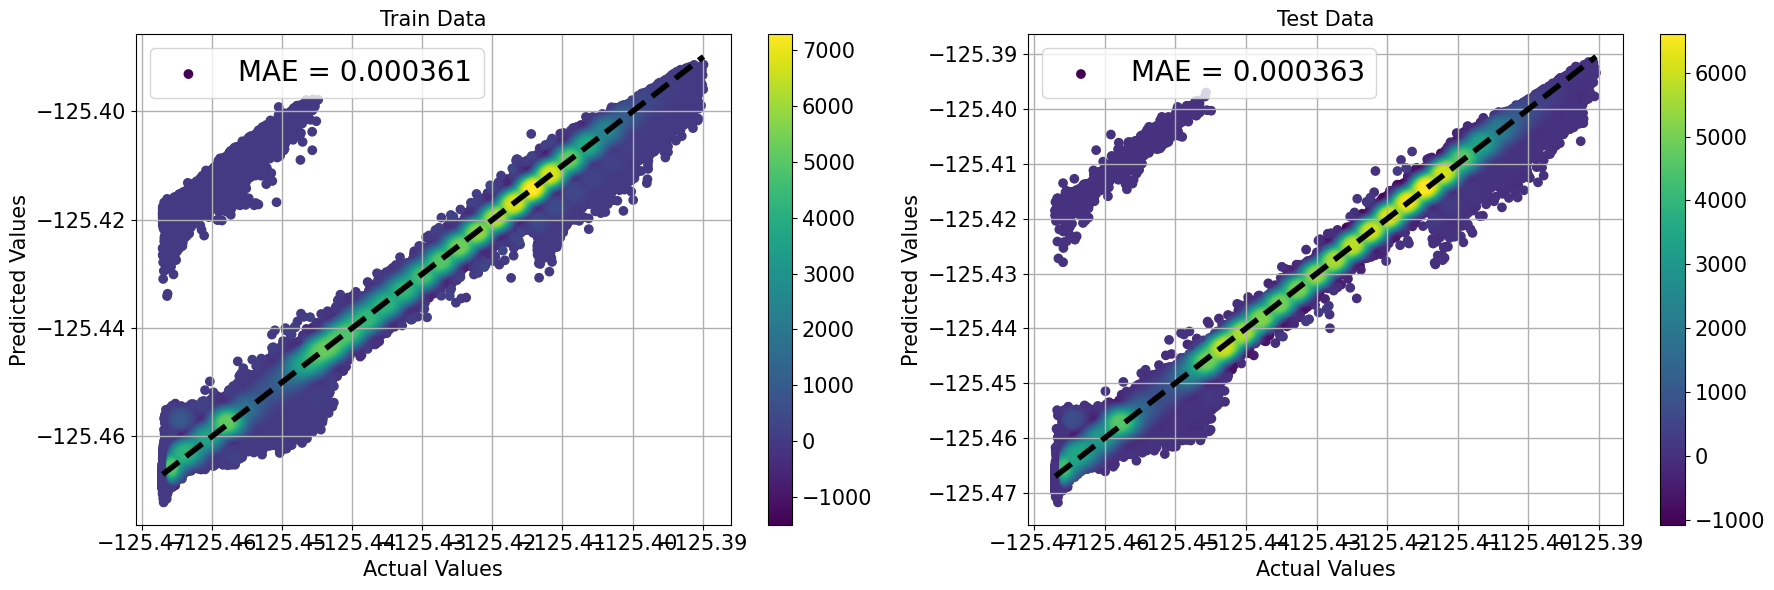

In [19]:
model_name = 'LGBM'

#Light GBM
score, best_params = hSML.Bayesian_optimization_LGBM(X_train, y_train,
                        pbounds = {
                                    'num_leaves': (20, 150),
                                    'max_depth': (3, 12),
                                    'learning_rate': (0.01, 0.3),
                                    'n_estimators': (50, 300)
                                }, n_iter=20)

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

# Evaluate the model
relation_square = model.score(X_train, y_train)
print('Relation coefficient: ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

2024-09-11 14:51:39.215944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43253 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:61:00.0, compute capability: 8.9
2024-09-11 14:51:39.217301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43403 MB memory:  -> device: 1, name: NVIDIA L40, pci bus id: 0000:e1:00.0, compute capability: 8.9


Epoch 1/300


I0000 00:00:1726066303.871008 2088122 service.cc:145] XLA service 0x7f6390006990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726066303.871068 2088122 service.cc:153]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
I0000 00:00:1726066303.871070 2088122 service.cc:153]   StreamExecutor device (1): NVIDIA L40, Compute Capability 8.9
2024-09-11 14:51:43.903155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-11 14:51:44.388562: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1726066305.414814 2088122 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_442_0', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_444_0', 4 bytes sp

258959/258959 ━━━━━━━━━━━━━━━━━━━━ 191s 722us/step - loss: 0.0217 - mae: 0.0335 - val_loss: 0.0062 - val_mae: 0.0142
Epoch 2/300
258959/258959 ━━━━━━━━━━━━━━━━━━━━ 190s 728us/step - loss: 0.0096 - mae: 0.0168 - val_loss: 0.0076 - val_mae: 0.0142
Epoch 3/300
258959/258959 ━━━━━━━━━━━━━━━━━━━━ 191s 733us/step - loss: 0.0079 - mae: 0.0147 - val_loss: 0.0090 - val_mae: 0.0130
Epoch 4/300
258959/258959 ━━━━━━━━━━━━━━━━━━━━ 191s 734us/step - loss: 0.0071 - mae: 0.0137 - val_loss: 0.0083 - val_mae: 0.0120
Epoch 5/300
258959/258959 ━━━━━━━━━━━━━━━━━━━━ 189s 723us/step - loss: 0.0064 - mae: 0.0130 - val_loss: 0.0027 - val_mae: 0.0102
Epoch 6/300
258959/258959 ━━━━━━━━━━━━━━━━━━━━ 190s 730us/step - loss: 0.0060 - mae: 0.0125 - val_loss: 0.0058 - val_mae: 0.0106
Epoch 7/300
258959/258959 ━━━━━━━━━━━━━━━━━━━━ 189s 727us/step - loss: 0.0056 - mae: 0.0121 - val_loss: 0.0053 - val_mae: 0.0093
Epoch 8/300
258959/258959 ━━━━━━━━━━━━━━━━━━━━ 188s 721us/step - loss: 0.0053 - mae: 0.0118 - val_loss: 0.011

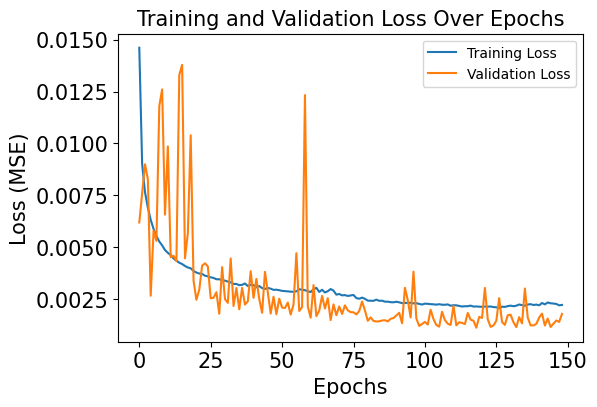

1294795/1294795 ━━━━━━━━━━━━━━━━━━━━ 602s 464us/step
323699/323699 ━━━━━━━━━━━━━━━━━━━━ 148s 456us/step


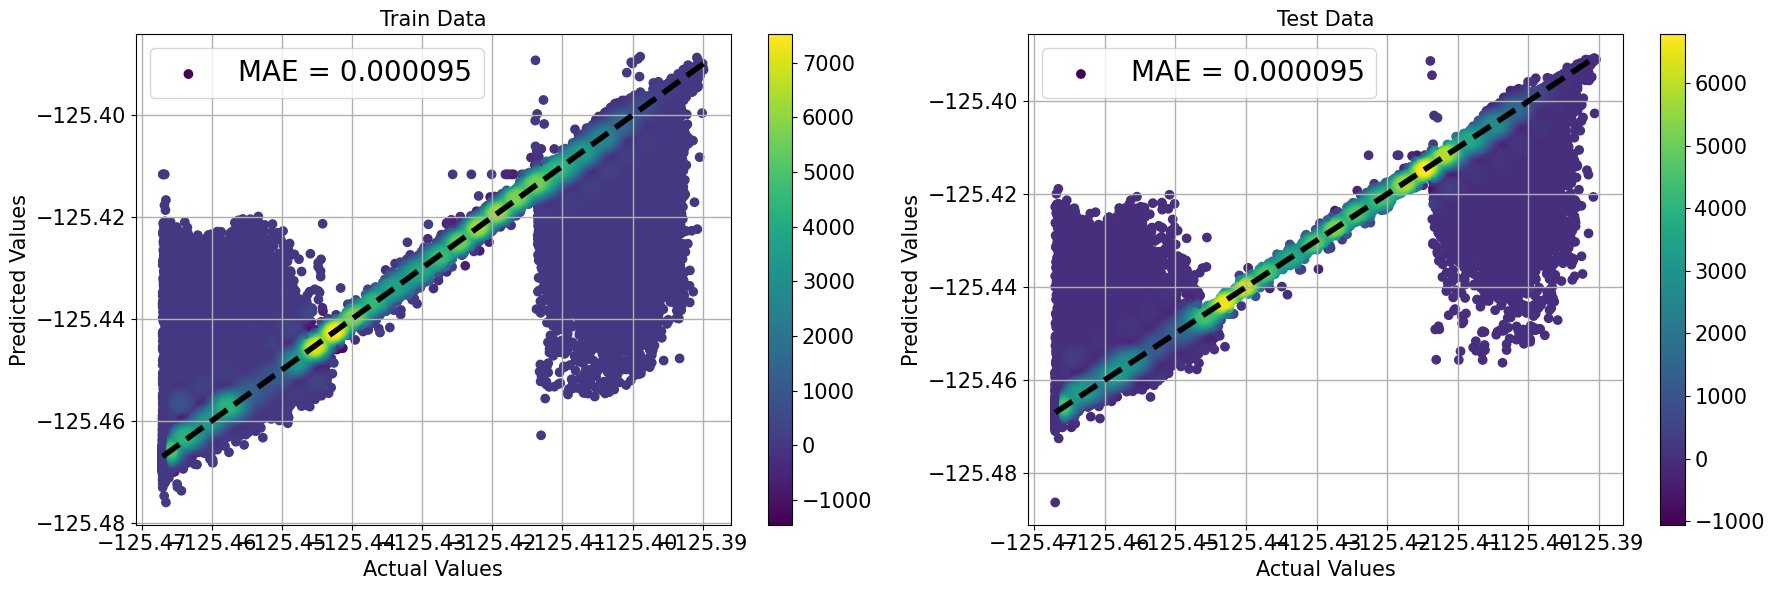

In [20]:
# NN with dropout/early stopping/adam #adagrad opti.
model_name = 'NN'

# Reproducibility
tf.random.set_seed(seed) #tensorflow
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism() #tensorflow reproducible
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
#Threads Num
#cpu_core = 20
#tf.config.threading.set_intra_op_parallelism_threads(cpu_core)
#tf.config.threading.set_inter_op_parallelism_threads(cpu_core)


# Define the model with Dropout layers
model = Sequential([
    Input(shape=(len(feature_imp_list),)),
    Dense(128, activation='relu'),
#    Dropout(0.2),                             
    Dense(64, activation='relu'),
#    Dropout(0.2),
    Dense(32, activation='relu'),
#    Dropout(0.2),
    Dense(16, activation='relu'),                     
#    Dropout(0.2), 
    Dense(1)                                          # Output layer for regression (no activation)
])
#BatchNormalization()


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), # default learning rate = 0.001 
              loss='mse',               # Mean Squared Error loss for regression
              metrics=['mae'])          # Mean Absolute Error as a metric


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) # Add early stopping to the training process
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
#                        min_lr=1e-6, verbose=1, min_delta=1e-5)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=300,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Plotting the loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()
plt.close()

# Save the model
model.save(f'{save_path}/{model_name}_model.keras')

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

In [ ]:
import os

beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(10)

In [9]:
#feature_imp_list = hSML.select_important_feature_list(feature_imp, 0.01)

feature_imp = pd.read_csv(f'{cpuserver_data_FP}/TCA_ML_project_SB/results/time_variant/{start_year}_{end_year}_{X_data_type}/feature_importance_{target_year}.csv')
rank_threshold = 20
feature_imp_list = list(feature_imp.head(rank_threshold)['feature'].values)
print(feature_imp_list)

np.shape(feature_imp_list)

['roughness', 'vegetation_water_content', 'vegetation_opacity', 'surface_water_fraction_mb_h', 'dist2water', 'soil_moisture', 'surface_water_fraction_mb_v', 'bulk_density', 'surface_temperature', 'albedo', 'DEM', 'CoastalMask', 'clay_fraction', 'tb_v_corrected', 'DEMSLPSTD', 'tb_h_corrected', 'DEMSTD', 'DEMSLP', 'bulk', 'sand']


(20,)

In [7]:
start_year = 2015; end_year = 2023; X_data_type = 'SMAP'
total_feature_imp = pd.DataFrame()
for year in range(start_year, end_year +1):
    feature_imp_year = pd.read_csv(f'{cpuserver_data_FP}/TCA_ML_project_SB/results/time_variant/{start_year}_{end_year}_{X_data_type}/feature_importance_{year}.csv')
    total_feature_imp[f'feature_{year}'] = feature_imp_year['feature'].values[:24]

flattened_series = total_feature_imp.values.flatten()

# Remove any NaN values (if they exist)
flattened_series = flattened_series[~pd.isnull(flattened_series)]

# Get the count of each unique value
value_counts = pd.Series(flattened_series).value_counts()

feature_imp_list = np.array(value_counts[value_counts == 9].index)
print(len(feature_imp_list), feature_imp_list, '\n')
feature_imp_list_2 = np.delete(feature_imp_list, np.argwhere(feature_imp_list=='tb_h_uncorrected')) # For top20
print(len(feature_imp_list_2), feature_imp_list_2, '\n')

#np.save(f'{cpuserver_data_FP}/TCA_ML_project_SB/results/time_variant/{start_year}_{end_year}_{X_data_type}/feature_importance_total.npy', feature_imp_list)
np.save(f'{cpuserver_data_FP}/TCA_ML_project_SB/results/time_variant/{start_year}_{end_year}_{X_data_type}/feature_importance_total.npy', feature_imp_list_2)

# Display the result
print(value_counts)
total_feature_imp

21 ['surface_water_fraction_mb_h' 'vegetation_opacity' 'roughness'
 'vegetation_water_content' 'tb_h_corrected' 'bulk_density' 'dist2water'
 'tb_v_uncorrected' 'clay_fraction' 'DEM' 'soil_moisture' 'CoastalMask'
 'surface_temperature' 'sand' 'albedo' 'DEMSLPSTD' 'boresight_incidence'
 'DEMSLP' 'DEMSTD' 'tb_v_corrected' 'tb_h_uncorrected'] 

20 ['surface_water_fraction_mb_h' 'vegetation_opacity' 'roughness'
 'vegetation_water_content' 'tb_h_corrected' 'bulk_density' 'dist2water'
 'tb_v_uncorrected' 'clay_fraction' 'DEM' 'soil_moisture' 'CoastalMask'
 'surface_temperature' 'sand' 'albedo' 'DEMSLPSTD' 'boresight_incidence'
 'DEMSLP' 'DEMSTD' 'tb_v_corrected'] 

surface_water_fraction_mb_h    9
vegetation_opacity             9
roughness                      9
vegetation_water_content       9
tb_h_corrected                 9
bulk_density                   9
dist2water                     9
tb_v_uncorrected               9
clay_fraction                  9
DEM                            9
soi

feature_2015                 feature_2016  \
0   surface_water_fraction_mb_h  surface_water_fraction_mb_h   
1                     roughness           vegetation_opacity   
2      vegetation_water_content     vegetation_water_content   
3                  bulk_density                   dist2water   
4            vegetation_opacity             tb_v_uncorrected   
5                           DEM                 bulk_density   
6                    dist2water                          DEM   
7    static_water_body_fraction                clay_fraction   
8     radar_water_body_fraction                  CoastalMask   
9                 soil_moisture          surface_temperature   
10                  CoastalMask                       albedo   
11                       albedo                    roughness   
12                clay_fraction                soil_moisture   
13                         sand                         sand   
14                    DEMSLPSTD    radar_water_body_fraction   
15                       DEMSTD   static_water_body_fraction   
16          surface_temperature          boresight_incidence   
17             tb_v_uncorrected                    DEMSLPSTD   
18                       DEMSLP                       DEMSLP   
19               tb_v_corrected                       DEMSTD   
20          boresight_incidence          retrieval_qual_flag   
21             tb_h_uncorrected               tb_v_corrected   
22               tb_h_corrected             tb_h_uncorrected   
23                UrbanFraction               tb_h_corrected   

                   feature_2017                 feature_2018  \
0   surface_water_fraction_mb_h  surface_water_fraction_mb_h   
1                     roughness                    roughness   
2      vegetation_water_content     vegetation_water_content   
3                  bulk_density           vegetation_opacity   
4                    dist2water                 bulk_density   
5                 soil_moisture   static_water_body_fraction   
6     radar_water_body_fraction                   dist2water   
7    static_water_body_fraction                          DEM   
8                           DEM          surface_temperature   
9           surface_temperature                soil_moisture   
10                clay_fraction    radar_water_body_fraction   
11                       albedo                  CoastalMask   
12                  CoastalMask                clay_fraction   
13                         sand                       albedo   
14           vegetation_opacity                         sand   
15          boresight_incidence                    DEMSLPSTD   
16                       DEMSTD          boresight_incidence   
17                       DEMSLP                       DEMSTD   
18               tb_v_corrected                       DEMSLP   
19             tb_v_uncorrected               tb_h_corrected   
20          retrieval_qual_flag             tb_v_uncorrected   
21                    DEMSLPSTD               tb_v_corrected   
22             tb_h_uncorrected                UrbanFraction   
23               tb_h_corrected             tb_h_uncorrected   

                   feature_2019                 feature_2020  \
0   surface_water_fraction_mb_h           vegetation_opacity   
1                     roughness  surface_water_fraction_mb_h   
2      vegetation_water_content     vegetation_water_content   
3              tb_v_uncorrected                 bulk_density   
4            vegetation_opacity                   dist2water   
5                   CoastalMask    radar_water_body_fraction   
6                    dist2water   static_water_body_fraction   
7                  bulk_density                          DEM   
8                 soil_moisture          surface_temperature   
9                           DEM                clay_fraction   
10                clay_fraction             tb_v_uncorrected   
11                       albedo                  

### Predictors & Outcome

In [10]:
feature_imp_list = np.load(f'{cpuserver_data_FP}/TCA_ML_project_SB/results/time_variant/{start_year}_{end_year}_{X_data_type}/feature_importance_total.npy', allow_pickle=True) # allow_pickle=True due to ValueError
print(feature_imp_list)

predictors = avail_data[feature_imp_list].values
outcome = avail_data['SMAP_VARerr'].values

# Standard scaling for predictors & outcome
predictors_scaled = scaler_X.fit_transform(predictors)
outcome_scaled = scaler_y.fit_transform(outcome.reshape(-1, 1)).flatten()
print(np.shape(predictors_scaled), np.shape(outcome_scaled))

X_train, X_test, y_train, y_test = train_test_split(predictors_scaled, outcome_scaled, test_size=0.2, random_state=seed)

['surface_water_fraction_mb_h' 'vegetation_opacity' 'roughness'
 'vegetation_water_content' 'tb_h_corrected' 'bulk_density' 'dist2water'
 'tb_v_uncorrected' 'clay_fraction' 'DEM' 'soil_moisture' 'CoastalMask'
 'surface_temperature' 'sand' 'albedo' 'DEMSLPSTD' 'boresight_incidence'
 'DEMSLP' 'DEMSTD' 'tb_v_corrected']


ValueError: 

### ML parts (RF)

In [16]:
model_name = 'RF'

warnings.filterwarnings("ignore", message="The number of bins", category=UserWarning)
warnings.filterwarnings("ignore", message="To use pickling first train using float32 data to fit the estimator", category=UserWarning)

score, best_params = hSML.Bayesian_optimization_RF(X_train, y_train,
                        pbounds={
                                'n_estimators': (10, 500),
                                'max_features': (0.1, 0.999),
                                'max_depth': (1, 100),
                                'min_samples_split': (2, 50)
                            }, n_iter=20, library_model='RF_cuml')

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = cuRF(**best_params, n_streams=1) # For reproducible (n_streams)
model.fit(X_train, y_train)
relation_square = model.score(X_train, y_train)
print('relation coefficient : ', relation_square)

# Save model
#joblib.dump(model, f'{save_path}/RF_model.pkl')

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

hPlot.plot_kde_scatter(y_train, y_pred_train, y_test, y_pred_test)

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_train':y_train,
                                'y_pred_train':y_pred_train})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_test':y_test,
                                'y_pred_test':y_pred_test})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------


KeyboardInterrupt: 

### ML part (XGB)

In [11]:
model_name = 'XGB'

# CuPy: CuPy is a GPU array library that is highly compatible with NumPy, making it easy to convert CPU-based NumPy arrays to GPU arrays.
#X_train = cp.array(X_train)
score, best_params = hSML.Bayesian_optimization_XGB(X_train, y_train,
                      pbounds={
                          'n_estimators': (10, 500),
                          'max_features': (0.1, 0.999),
                          'max_depth': (1, 100),
                          'min_samples_split': (2, 50)
                      }, n_iter=20)

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

# Evaluate the model
relation_square = model.score(X_train, y_train)
print('Relation coefficient: ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------


KeyboardInterrupt: 

### ML part (SVM)

In [ ]:
model_name = 'SVM'

score, best_params = hSML.Bayesian_optimization_SVM(X_train, y_train,
                        pbounds = {
                                    'C': (0.1, 100),
                                    'epsilon': (0.01, 1),
                                    'gamma': (0.01, 1),
                                    'degree': (2, 5)  # Only used if kernel is 'poly'
                                }, n_iter=20, library_model='SVM_cuml')

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = SVR(**best_params)
model.fit(X_train, y_train) #, eval_set=[(X_train, y_train), (X_test, y_test)])

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

# Evaluate the model
relation_square = model.score(X_train, y_train)
print('Relation coefficient: ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

|   iter    |  target   |     C     |  degree   |  epsilon  |   gamma   |
-------------------------------------------------------------------------


### ML part (LGBM)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
| 1         | -0.2451   | 0.1692    | 9.437     | 200.7     | 90.83     |
| 2         | -0.2464   | 0.1329    | 8.813     | 159.4     | 135.9     |
| 3         | -0.241    | 0.1871    | 8.307     | 200.0     | 90.97     |
| 4         | -0.3073   | 0.2207    | 4.809     | 111.4     | 43.81     |
| 5         | -0.2246   | 0.3       | 3.0       | 185.6     | 94.38     |
| 6         | -0.2131   | 0.3       | 3.0       | 192.4     | 114.9     |
| 7         | -0.2022   | 0.3       | 3.0       | 206.4     | 134.9     |
| 8         | -0.2209   | 0.1533    | 3.0       | 231.9     | 137.2     |
| 9         | -0.3938   | 0.01      | 12.0      | 196.1     | 150.0     |
| 10        | -0.2058   | 0.3       | 3.0       | 212.5     | 122.1     |
| 11        | -0.2197   | 0.1912    | 12.0      | 233.1     | 117.1     |
| 12        | -0.1971   | 0.3       | 

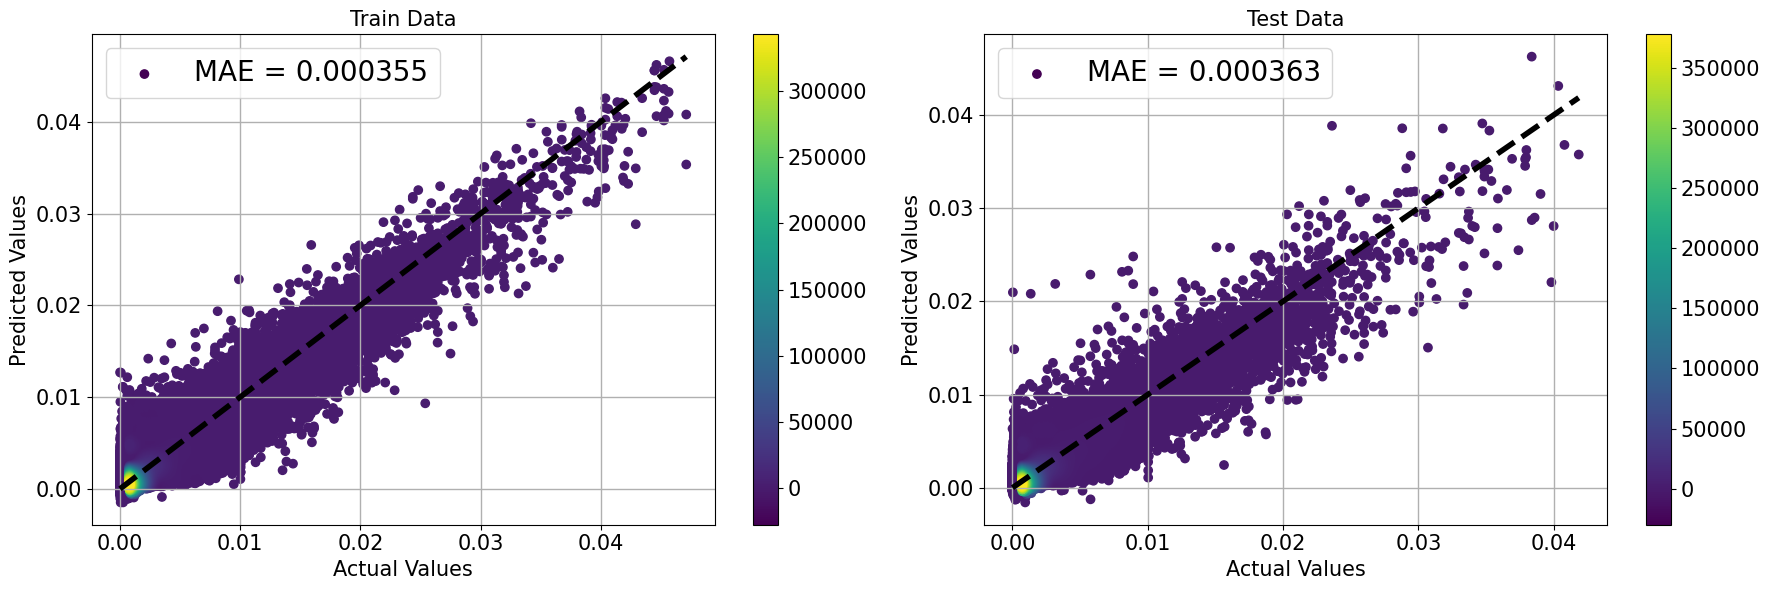

In [9]:
model_name = 'LGBM'

#Light GBM
score, best_params = hSML.Bayesian_optimization_LGBM(X_train, y_train,
                        pbounds = {
                                    'num_leaves': (20, 150),
                                    'max_depth': (3, 12),
                                    'learning_rate': (0.01, 0.3),
                                    'n_estimators': (50, 300)
                                }, n_iter=20)

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

# Evaluate the model
relation_square = model.score(X_train, y_train)
print('Relation coefficient: ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

### ElasticNet

|   iter    |  target   |   alpha   | l1_ratio  |
-------------------------------------------------
| 1         | -1.001    | 5.493     | 0.718     |
| 2         | -1.001    | 6.032     | 0.5494    |
| 3         | -0.6285   | 0.01306   | 0.02671   |
| 4         | -0.638    | 0.01      | 1.0       |
| 5         | -1.001    | 10.0      | 1.0       |
| 6         | -0.7207   | 0.9943    | 0.01      |
| 7         | -0.6313   | 0.01      | 0.3842    |
| 8         | -0.6277   | 0.01      | 0.01      |
| 9         | -0.6277   | 0.01      | 0.01      |
| 10        | -0.6277   | 0.01      | 0.01      |
| 11        | -0.6277   | 0.01      | 0.01      |
| 12        | -0.6277   | 0.01      | 0.01      |
| 13        | -0.6277   | 0.01      | 0.01      |
| 14        | -0.6277   | 0.01      | 0.01      |
| 15        | -0.6277   | 0.01      | 0.01      |
| 16        | -0.6277   | 0.01      | 0.01      |
| 17        | -0.6277   | 0.01      | 0.01      |
| 18        | -0.6277   | 0.01      | 0.01      |


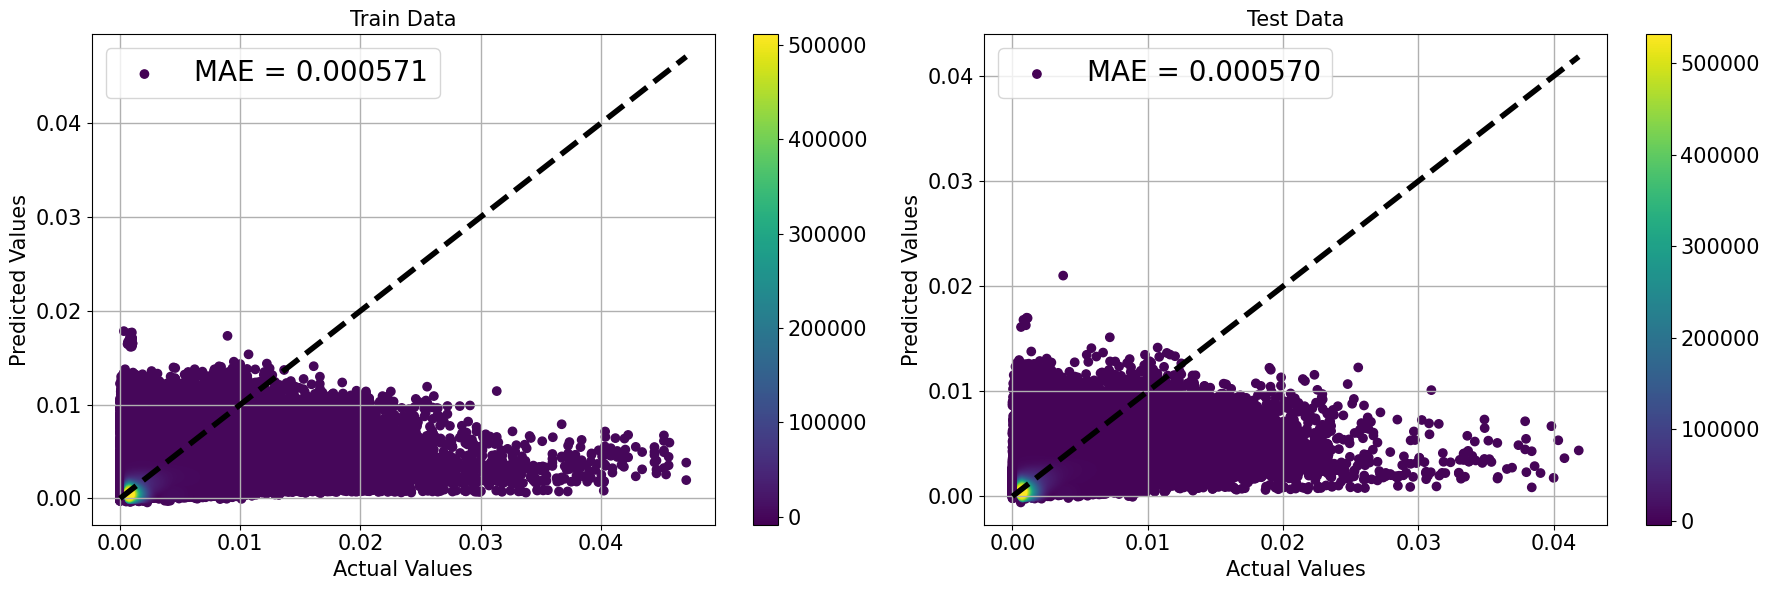

In [10]:
model_name = 'ElasticNet'

score, best_params = hSML.Bayesian_optimization_ElasticNet(X_train, y_train,
                      pbounds={
                            'alpha': (0.1, 10),    # 0 to ~
                            'l1_ratio': (0.1, 1.0) # 0 to 1
                      }, n_iter=20)

with open(f'{save_path}/{model_name}_bayesian_best_params.json','w') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

model = cuML_ElasticNet(**best_params)
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'{save_path}/{model_name}_model.pkl')

# Evaluate the model
relation_square = model.score(X_train, y_train)
print('Relation coefficient: ', relation_square)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

### Neural Network

In [ ]:
# NN with dropout/early stopping/adam #adagrad opti.
model_name = 'NN'

# Reproducibility
tf.random.set_seed(seed) #tensorflow
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism() #tensorflow reproducible
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
#Threads Num
#cpu_core = 20
#tf.config.threading.set_intra_op_parallelism_threads(cpu_core)
#tf.config.threading.set_inter_op_parallelism_threads(cpu_core)


# Define the model with Dropout layers
model = Sequential([
    Input(shape=(20,)),
    Dense(128, activation='relu'),
#    Dropout(0.2),                             
    Dense(64, activation='relu'),
#    Dropout(0.2),
    Dense(32, activation='relu'),
#    Dropout(0.2),
    Dense(16, activation='relu'),                     
#    Dropout(0.2), 
    Dense(1)                                          # Output layer for regression (no activation)
])
#BatchNormalization()


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), # default learning rate = 0.001 
              loss='mse',               # Mean Squared Error loss for regression
              metrics=['mae'])          # Mean Absolute Error as a metric


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) # Add early stopping to the training process
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
#                        min_lr=1e-6, verbose=1, min_delta=1e-5)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=1000,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Plotting the loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()
plt.close()

# Save the model
model.save(f'{save_path}/{model_name}_model.keras')

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()

# Save pred & true dataframe
df_pred_true_train = pd.DataFrame({'y_true_train':y_train_original,
                                'y_pred_train':y_pred_train_original})
df_pred_true_train.to_csv(f'{save_path}/{model_name}_predtrue_train.csv', sep=',', index=False)

df_pred_true_test = pd.DataFrame({'y_true_test':y_test_original,
                                'y_pred_test':y_pred_test_original})
df_pred_true_test.to_csv(f'{save_path}/{model_name}_predtrue_test.csv', sep=',', index=False)

hPlot.plot_kde_scatter(y_train_original, y_pred_train_original, y_test_original, y_pred_test_original)

Epoch 1/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - loss: 0.4651 - mae: 0.3878 - val_loss: 0.3846 - val_mae: 0.3597
Epoch 2/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 0.3806 - mae: 0.3623 - val_loss: 0.3591 - val_mae: 0.3540
Epoch 3/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 0.3569 - mae: 0.3553 - val_loss: 0.3453 - val_mae: 0.3508
Epoch 4/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 35s 985us/step - loss: 0.3409 - mae: 0.3508 - val_loss: 0.3321 - val_mae: 0.3460
Epoch 5/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 35s 983us/step - loss: 0.3296 - mae: 0.3477 - val_loss: 0.3273 - val_mae: 0.3439
Epoch 6/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 34s 952us/step - loss: 0.3217 - mae: 0.3455 - val_loss: 0.3226 - val_mae: 0.3434
Epoch 7/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 35s 988us/step - loss: 0.3149 - mae: 0.3435 - val_loss: 0.3195 - val_mae: 0.3428
Epoch 8/1000
35274/35274 ━━━━━━━━━━━━━━━━━━━━ 34s 974us/step - loss: 0.3096 - mae: 0.3418 - val_loss: 0.3119 - val_ma

### Reconstruct

In [9]:
# Predictors of need_to_reconstruct
predictors_2 = need_to_reconstruct[feature_imp_list].values
predictors_scaled_2 = scaler_X.fit_transform(predictors_2)

indices_to_update = list(need_to_reconstruct['original_index'])

In [10]:
# Neural Network's param

'''
# Best RF model's param
with open(f'{save_path}/RF_bayesian_best_params.json', 'r') as file:
    best_params_loaded_RF = json.load(file)
model_loaded_RF = cuRF(**best_params_loaded_RF)
model_loaded_RF.fit(predictors_scaled, outcome)
y_pred_2_RF = model_loaded_RF.predict(predictors_scaled_2)
'''

'''
# Best XGB model's param
with open(f'{save_path}/XGB_bayesian_best_params.json', 'r') as file:
    best_params_loaded_XGB = json.load(file)
model_loaded_XGB = xgb.XGBRegressor(**best_params_loaded_XGB)
model_loaded_XGB.fit(predictors_scaled, outcome_scaled)
y_pred_2_XGB = model_loaded_XGB.predict(predictors_scaled_2)
y_pred_2_XGB_original = scaler_y.inverse_transform(y_pred_2_XGB.reshape(-1, 1)).ravel()
'''

'''
# Best SVM model's param
with open(f'{save_path}/SVM_bayesian_best_params.json', 'r') as file:
    best_params_loaded_SVM = json.load(file)
model_loaded_SVM = SVR(**best_params_loaded_SVM)
model_loaded_SVM.fit(predictors_scaled, outcome_scaled)
y_pred_2_SVM = model_loaded_SVM.predict(predictors_scaled_2)
y_pred_2_SVM_original = scaler_y.inverse_transform(y_pred_2_SVM.reshape(-1, 1)).ravel()
'''

# Best LGBM model's param
with open(f'{save_path}/LGBM_bayesian_best_params.json', 'r') as file:
    best_params_loaded_LGBM = json.load(file)
model_loaded_LGBM = lgb.LGBMRegressor(**best_params_loaded_LGBM)
model_loaded_LGBM.fit(predictors_scaled, outcome_scaled)
y_pred_2_LGBM = model_loaded_LGBM.predict(predictors_scaled_2)
y_pred_2_LGBM_original = scaler_y.inverse_transform(y_pred_2_LGBM.reshape(-1, 1)).ravel()


# Best ElasticNet model's param
with open(f'{save_path}/ElasticNet_bayesian_best_params.json', 'r') as file:
    best_params_loaded_ElasticNet = json.load(file)
model_loaded_ElasticNet = cuML_ElasticNet(**best_params_loaded_ElasticNet)
model_loaded_ElasticNet.fit(predictors_scaled, outcome_scaled)
y_pred_2_ElasticNet = model_loaded_ElasticNet.predict(predictors_scaled_2)
y_pred_2_ElasticNet_original = scaler_y.inverse_transform(y_pred_2_ElasticNet.reshape(-1, 1)).ravel()

# Load NN best model
model_loaded_NN = keras.models.load_model(f'{save_path}/NN_model.keras')
# No training model due to time consuming
y_pred_2_NN = model_loaded_NN.predict(predictors_scaled_2)
y_pred_2_NN_original = scaler_y.inverse_transform(y_pred_2_NN.reshape(-1, 1)).ravel()

[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 7054671, number of used features: 20
[LightGBM] [Info] Start training from score -0.000000


2024-08-28 13:37:01.895282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43241 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:61:00.0, compute capability: 8.9
2024-08-28 13:37:01.896955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 41382 MB memory:  -> device: 1, name: NVIDIA L40, pci bus id: 0000:e1:00.0, compute capability: 8.9
I0000 00:00:1724852224.085698 1489848 service.cc:145] XLA service 0x7f8dc0004320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724852224.085747 1489848 service.cc:153]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
I0000 00:00:1724852224.085750 1489848 service.cc:153]   StreamExecutor device (1): NVIDIA L40, Compute Capability 8.9
2024-08-28 13:37:04.090194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] 

   275/278395 ━━━━━━━━━━━━━━━━━━━━ 2:33 552us/step

I0000 00:00:1724852224.616304 1489848 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


278395/278395 ━━━━━━━━━━━━━━━━━━━━ 127s 453us/step


In [11]:
# Updates
#df_recons['SMAP_VARerr_recons_RF'] = df_recons['SMAP_VARerr'].values
#df_recons.iloc[indices_to_update, df_recons.columns.get_loc('SMAP_VARerr_recons_RF')] = y_pred_2_RF

#df_recons['SMAP_VARerr_recons_XGB'] = df_recons['SMAP_VARerr'].values
#df_recons.iloc[indices_to_update, df_recons.columns.get_loc('SMAP_VARerr_recons_XGB')] = y_pred_2_XGB_original

#df_recons['SMAP_VARerr_recons_SVM'] = df_recons['SMAP_VARerr'].values
#df_recons.iloc[indices_to_update, df_recons.columns.get_loc('SMAP_VARerr_recons_SVM')] = y_pred_2_SVM_original

df_recons['SMAP_VARerr_recons_LGBM'] = df_recons['SMAP_VARerr'].values
df_recons.iloc[indices_to_update, df_recons.columns.get_loc('SMAP_VARerr_recons_LGBM')] = y_pred_2_LGBM_original

df_recons['SMAP_VARerr_recons_ElasticNet'] = df_recons['SMAP_VARerr'].values
df_recons.iloc[indices_to_update, df_recons.columns.get_loc('SMAP_VARerr_recons_ElasticNet')] = y_pred_2_ElasticNet_original

df_recons['SMAP_VARerr_recons_NN'] = df_recons['SMAP_VARerr'].values
df_recons.iloc[indices_to_update, df_recons.columns.get_loc('SMAP_VARerr_recons_NN')] = y_pred_2_NN_original

# Save df_recons
df_recons.to_csv(f'{save_path}/SMAP_VARerr_reconstruct.csv', sep=',', index=False)
print(np.shape(df_recons))

/tmp/ipykernel_1489429/2968412977.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.99982737e-05  3.39532711e-05 -8.04462175e-05 ...  2.39432709e-03
  2.50199793e-03  2.87650121e-03]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_recons.iloc[indices_to_update, df_recons.columns.get_loc('SMAP_VARerr_recons_LGBM')] = y_pred_2_LGBM_original


(68649210, 13)


In [12]:
df_recons = pd.read_csv(f'{save_path}/SMAP_VARerr_reconstruct.csv')
print(len(df_recons['SMAP_VARerr']))
df_recons

68649210


original_index  SMAP_VARerr  available  lat_index  lon_index  \
0                      0          NaN          0          0        266   
1                      1          NaN          0          0        266   
2                      2          NaN          0          0        266   
3                      3          NaN          0          0        266   
4                      4          NaN          0          0        266   
...                  ...          ...        ...        ...        ...   
68649205        68649205          NaN          0        371        299   
68649206        68649206          NaN          0        371        299   
68649207        68649207          NaN          0        371        299   
68649208        68649208          NaN          0        371        299   
68649209        68649209          NaN          0        371        299   

          time_index  flags_corr  flags_n_valid  flags_fMSE  \
0                  0         0.0            1.0         0.0   
1                  1         0.0            1.0         0.0   
2                  2         0.0            1.0         0.0   
3                  3         0.0            1.0         0.0   
4                  4         0.0            1.0         0.0   
...              ...         ...            ...         ...   
68649205         625         0.0            1.0         0.0   
68649206         626         0.0            1.0         0.0   
68649207         627         0.0            1.0         0.0   
68649208         628         0.0            1.0         0.0   
68649209         629         0.0            1.0         0.0   

          flags_negative_vars_err  SMAP_VARerr_recons_LGBM  \
0                             0.0                      NaN   
1                             0.0                      NaN   
2                             0.0                      NaN   
3                             0.0                      NaN   
4                             0.0                      NaN   
...                           ...                      ...   
68649205                      0.0                      NaN   
68649206                      0.0                      NaN   
68649207                      0.0                      NaN   
68649208                      0.0                      NaN   
68649209                      0.0                      NaN   

          SMAP_VARerr_recons_ElasticNet  SMAP_VARerr_recons_NN  
0                                   NaN                    NaN  
1                                   NaN                    NaN  
2                                   NaN                    NaN  
3                                   NaN                    NaN  
4                                   NaN                    NaN  
...                                 ...                    ...  
68649205                            NaN                    NaN  
68649206                            NaN                    NaN  
68649207                            NaN                    NaN  
68649208                            NaN                    NaN  
68649209                            NaN                    NaN  

[68649210 rows x 13 columns]

In [13]:
lat_lon_df = df_recons[['lat_index', 'lon_index']].copy()
unique_combinations = lat_lon_df.drop_duplicates()
unique_combinations_list = list(unique_combinations.itertuples(index=False, name=None))

np.shape(unique_combinations_list)

(108967, 2)

In [14]:
data_vars = {}

var_name_list = ['SMAP_VARerr', 'SMAP_VARerr_recons_LGBM', 'SMAP_VARerr_recons_ElasticNet', 'SMAP_VARerr_recons_NN']
var_name_list += ['flags_corr', 'flags_n_valid', 'flags_fMSE', 'flags_negative_vars_err']

for var_name in var_name_list:
    # Extract the necessary columns
    data = df_recons[['lat_index', 'lon_index', var_name]]
    
    # Create a MultiIndex from 'lat_index' and 'lon_index'
    multi_index = pd.MultiIndex.from_frame(data[['lat_index', 'lon_index']])
    
    # Use groupby to aggregate and create a list of values for each (lat_index, lon_index)
    grouped = data.groupby(['lat_index', 'lon_index'])[var_name].apply(list)
    
    # Find the maximum number of values for any (lat_index, lon_index) pair
    time_length = grouped.apply(len).max()
    
    # Create a 3D array initialized with NaNs
    recons_save = np.full((m, n, time_length), np.nan).astype('float32')
    
    # Vectorized assignment: fill the array without explicit loops
    for (lat_idx, lon_idx), values in grouped.items():
        recons_save[lat_idx, lon_idx, :] = values
    
    data_vars[var_name] = recons_save
    print(var_name, np.shape(values))

# To avoid permission error (due to already exist file)
nc_file_path = f'{save_path}/SMAP_VARerr_reconstruct.nc'
if os.path.exists(nc_file_path):
    os.remove(nc_file_path)
    print(f'File {nc_file_path} has been deleted.')

hData.create_netcdf_file(nc_file=nc_file_path,
                         latitude=domain_lat,
                         longitude=domain_lon,
                         **data_vars)

SMAP_VARerr (630,)
SMAP_VARerr_recons_LGBM (630,)
SMAP_VARerr_recons_ElasticNet (630,)
SMAP_VARerr_recons_NN (630,)
flags_corr (630,)
flags_n_valid (630,)
flags_fMSE (630,)
flags_negative_vars_err (630,)
File /home/subin/cpuserver_data/TCA_ML_project_SB/results/time_variant/2015_2023_SMAP/ML_2015/SMAP_VARerr_reconstruct.nc has been deleted.
NetCDF file /home/subin/cpuserver_data/TCA_ML_project_SB/results/time_variant/2015_2023_SMAP/ML_2015/SMAP_VARerr_reconstruct.nc created successfully.


/tmp/ipykernel_1489429/2333662523.py:1: RuntimeWarning: Mean of empty slice
  target = np.nanmean(data_vars['SMAP_VARerr'], axis=2)


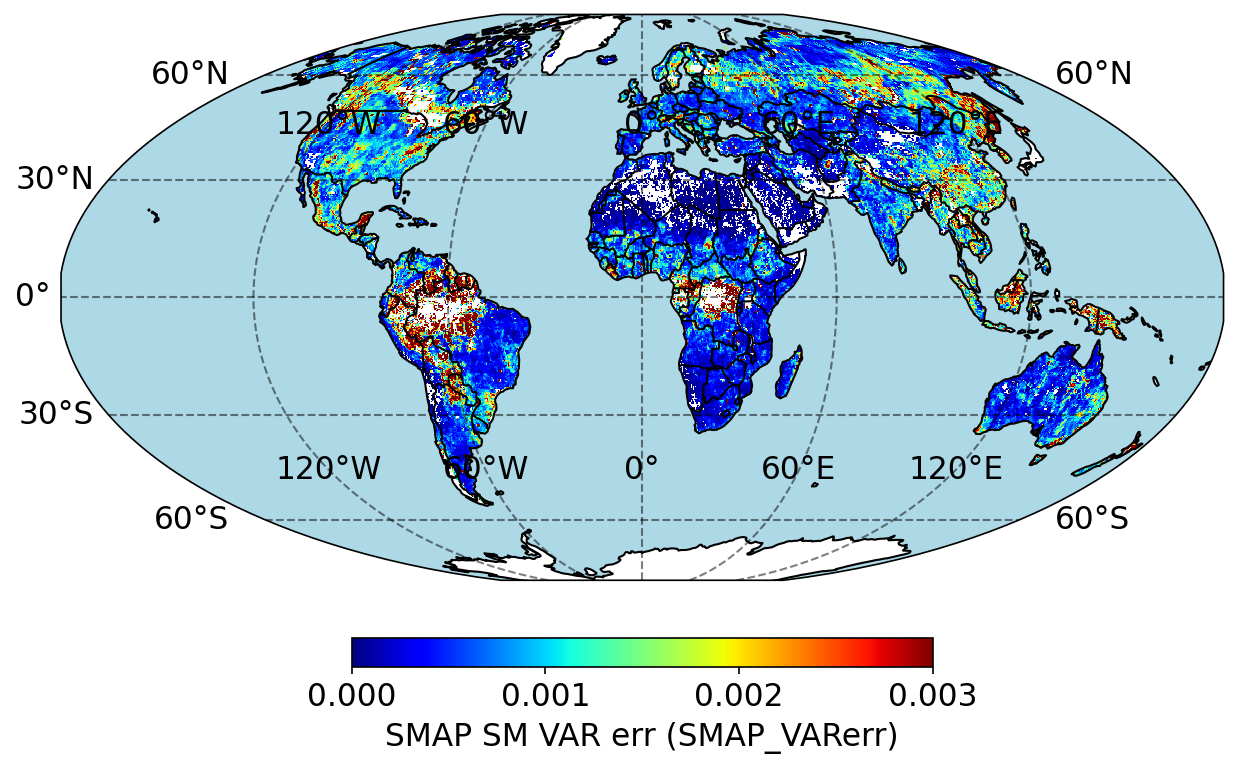

/tmp/ipykernel_1489429/2333662523.py:4: RuntimeWarning: Mean of empty slice
  target = np.nanmean(data_vars['SMAP_VARerr_recons_LGBM'], axis=2)


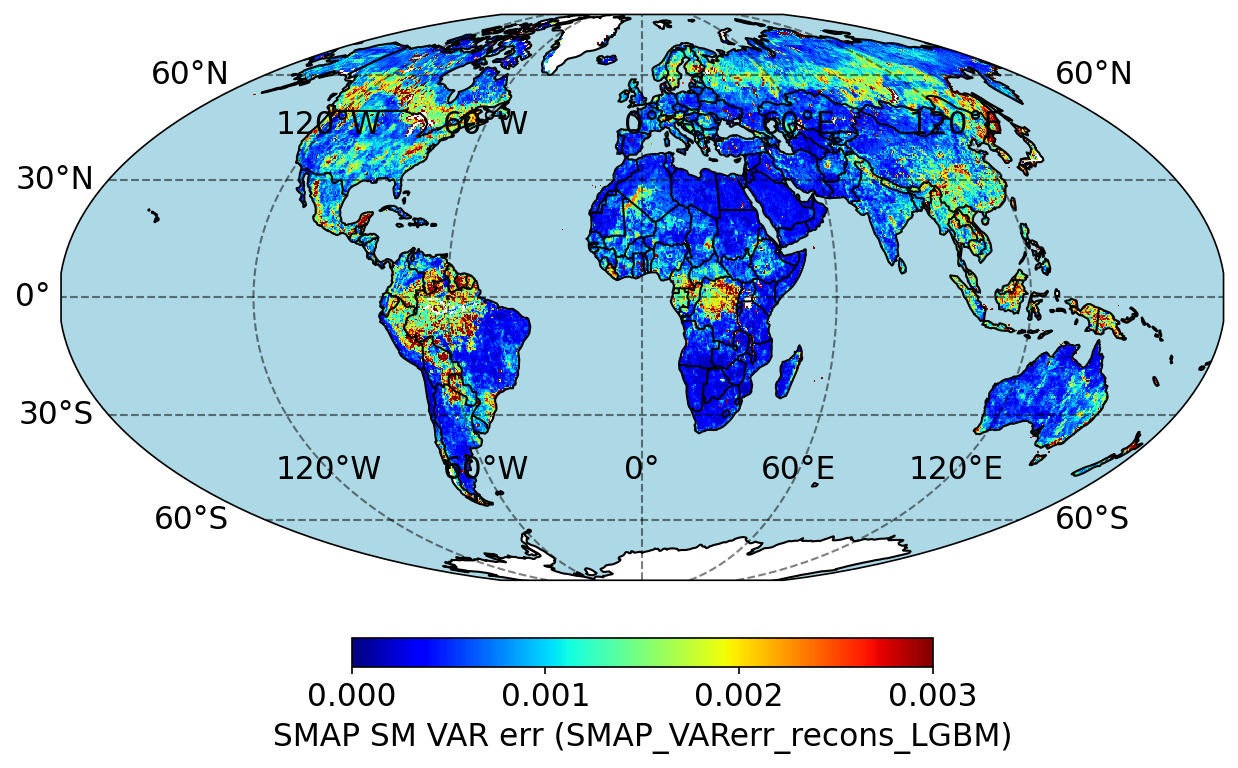

/tmp/ipykernel_1489429/2333662523.py:7: RuntimeWarning: Mean of empty slice
  target = np.nanmean(data_vars['SMAP_VARerr_recons_ElasticNet'], axis=2)


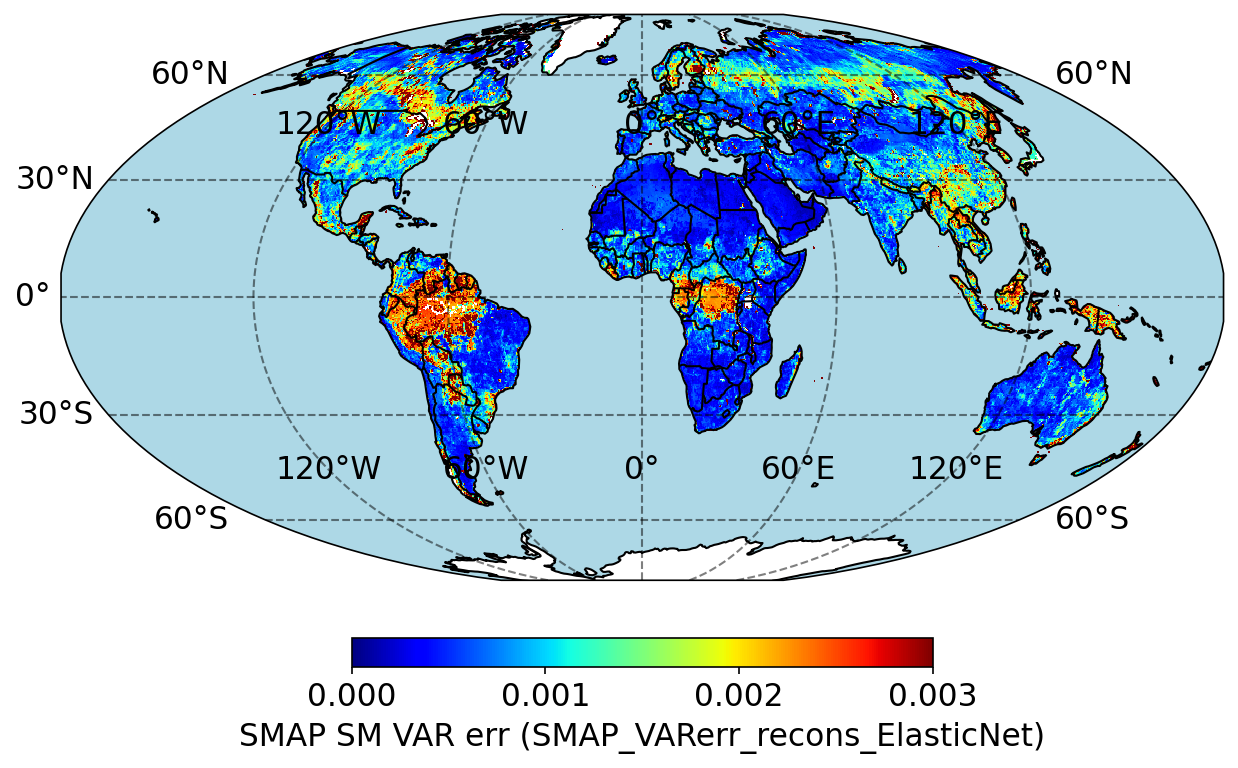

/tmp/ipykernel_1489429/2333662523.py:10: RuntimeWarning: Mean of empty slice
  target = np.nanmean(data_vars['SMAP_VARerr_recons_NN'], axis=2)


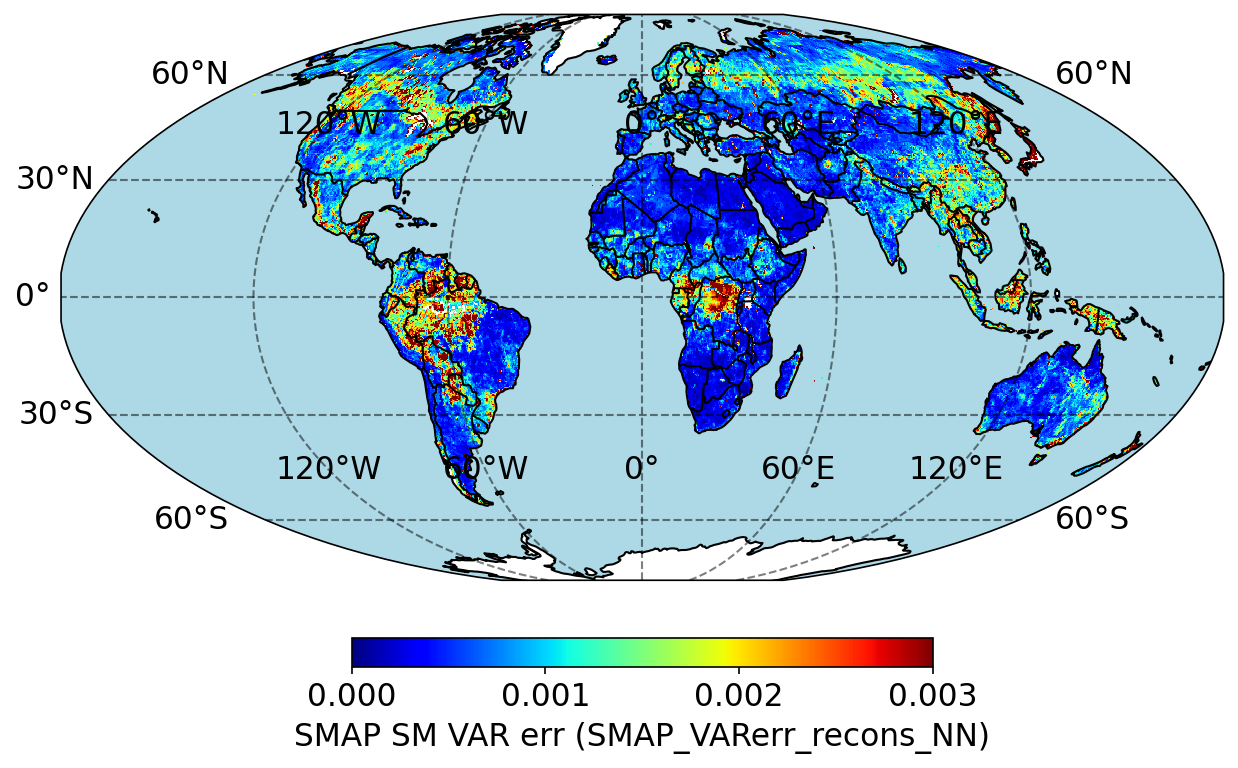

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [15]:
target = np.nanmean(data_vars['SMAP_VARerr'], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr)')

target = np.nanmean(data_vars['SMAP_VARerr_recons_LGBM'], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr_recons_LGBM)')

target = np.nanmean(data_vars['SMAP_VARerr_recons_ElasticNet'], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr_recons_ElasticNet)')

target = np.nanmean(data_vars['SMAP_VARerr_recons_NN'], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr_recons_NN)')

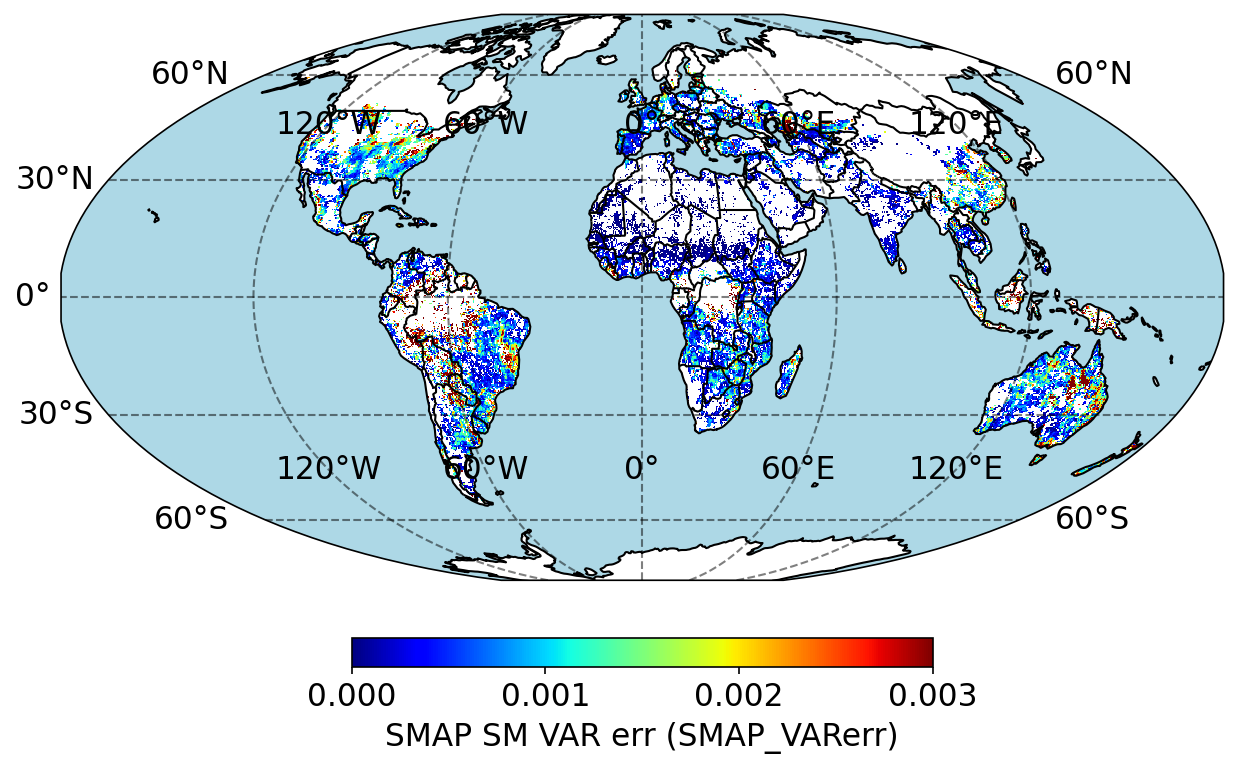

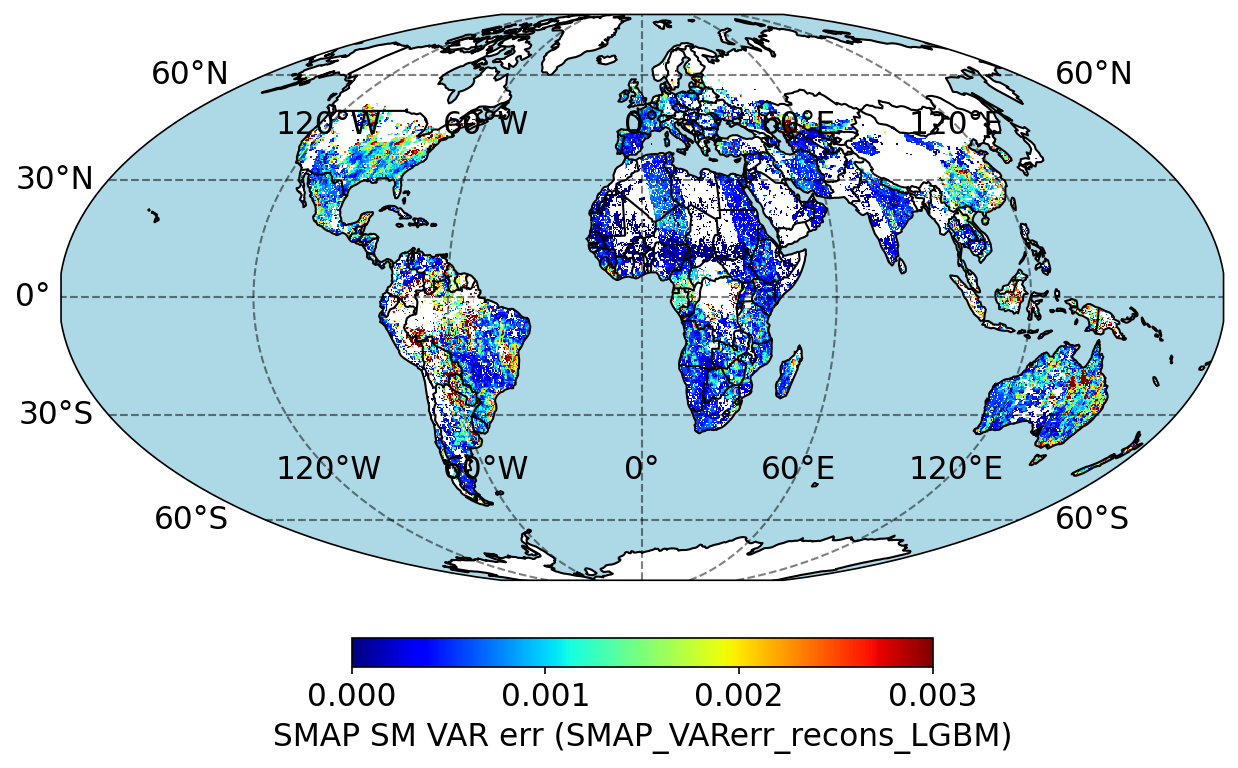

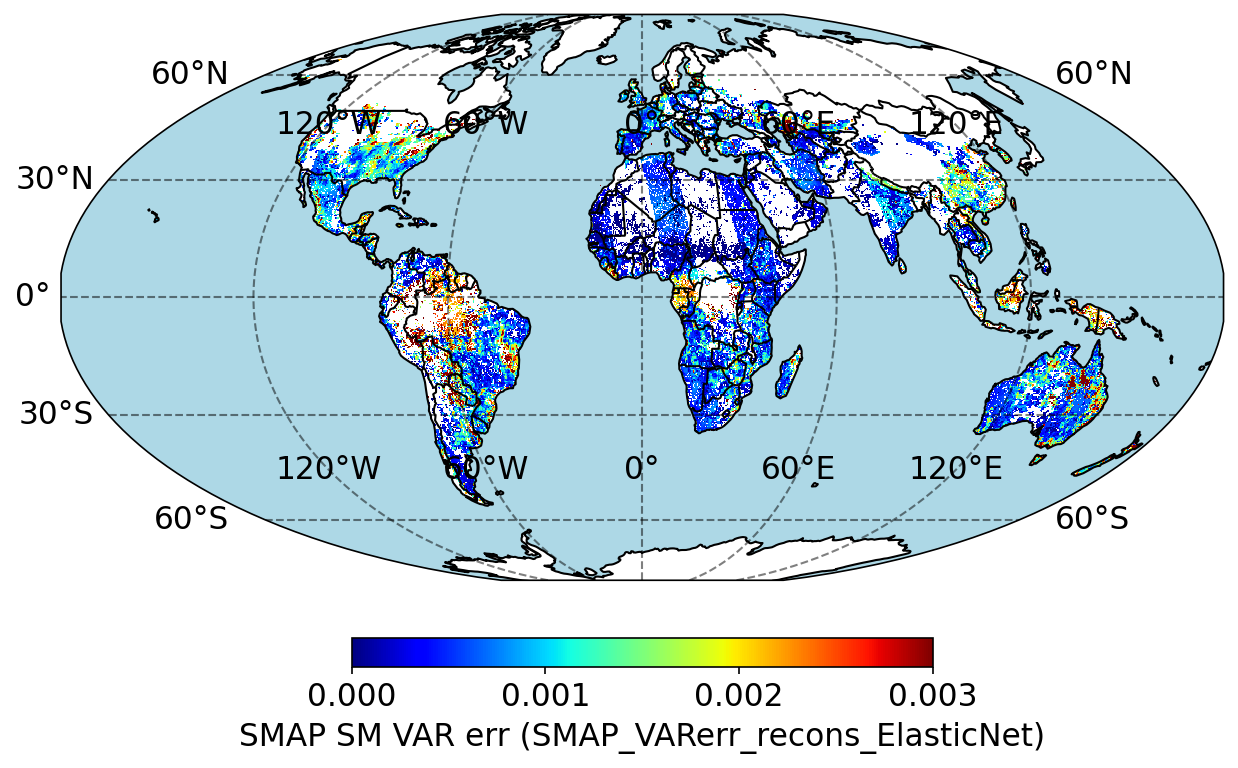

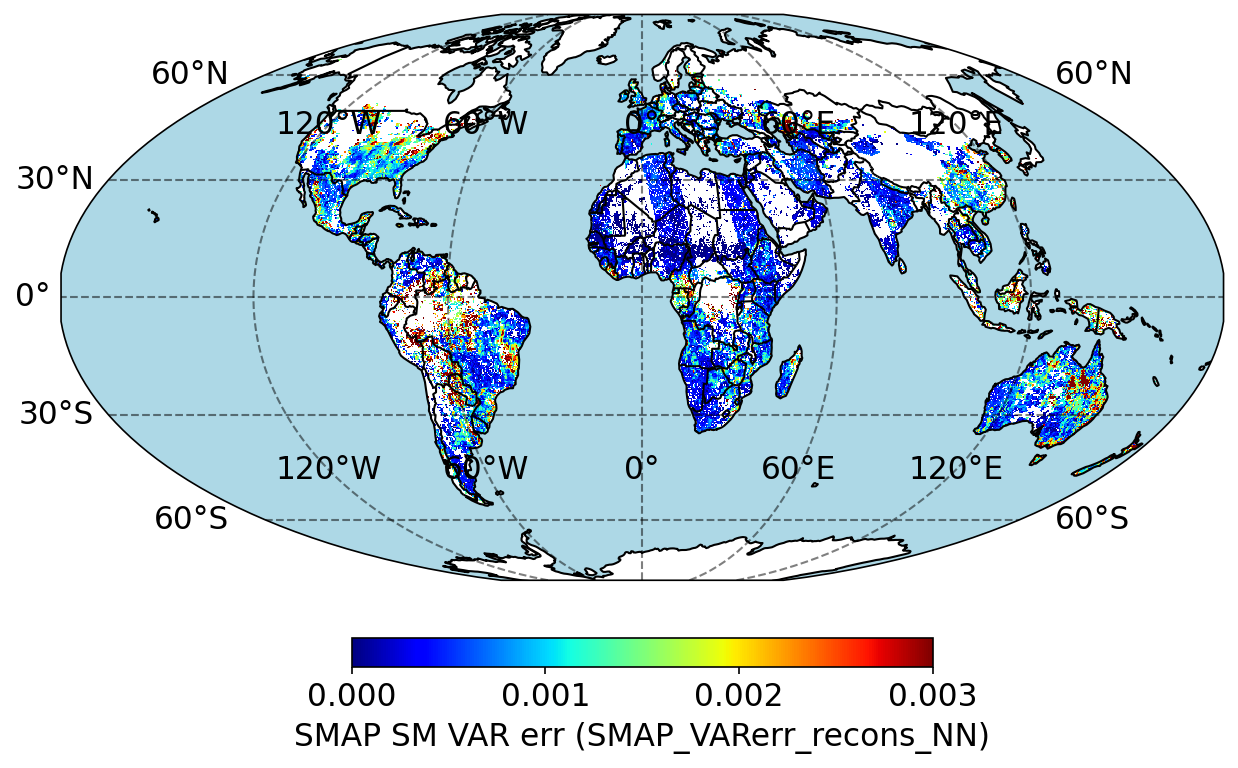

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [16]:
target = data_vars['SMAP_VARerr'][:, :, -1]
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr)')

target = data_vars['SMAP_VARerr_recons_LGBM'][:, :, -1]
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr_recons_LGBM)')

target = data_vars['SMAP_VARerr_recons_ElasticNet'][:, :, -1]
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr_recons_ElasticNet)')

target = data_vars['SMAP_VARerr_recons_NN'][:, :, -1]
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0030, label_title=f'SMAP SM VAR err (SMAP_VARerr_recons_NN)')

In [17]:
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
beep(10)



0

### Check raw TC dataset

/tmp/ipykernel_790663/173454836.py:8: RuntimeWarning: Mean of empty slice
  target = np.nanmean(check_temp_TV, axis=2)


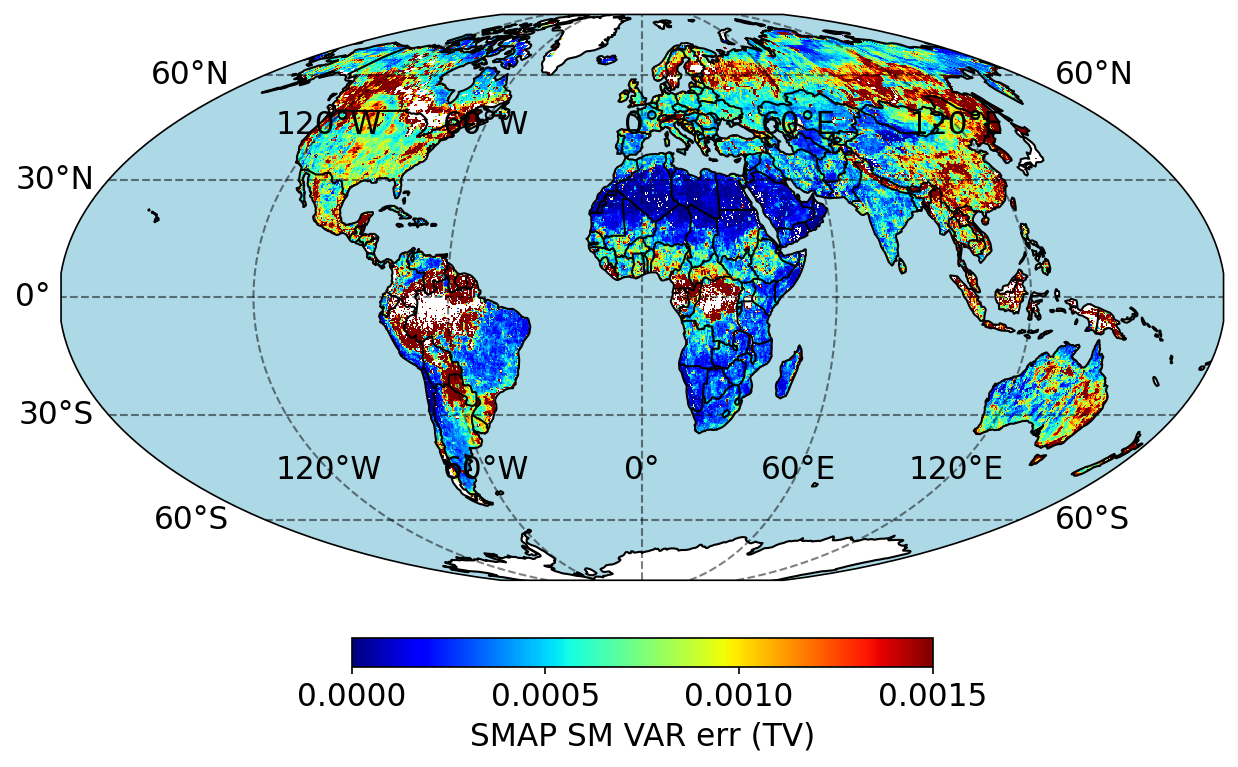

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [3]:
with netCDF4.Dataset(f'{cpuserver_data_FP}/TCA_ML_project_SB/removeSeasonality/2015_2023/TCA_VARerr_TV_WS91_nodTh25_corrTh0.nc') as nc_data_GLDAS:
    check_temp_TV = nc_data_GLDAS.variables['TCA_VAR_err1'][:].data

projection_grid = 'EASE2_M36km'
domain_lon, domain_lat = hSMAP.get_e2grid(cpuserver_data_FP, '36km')
m, n = np.shape(domain_lat)

target = np.nanmean(check_temp_TV, axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0015, label_title=f'SMAP SM VAR err (TV)')

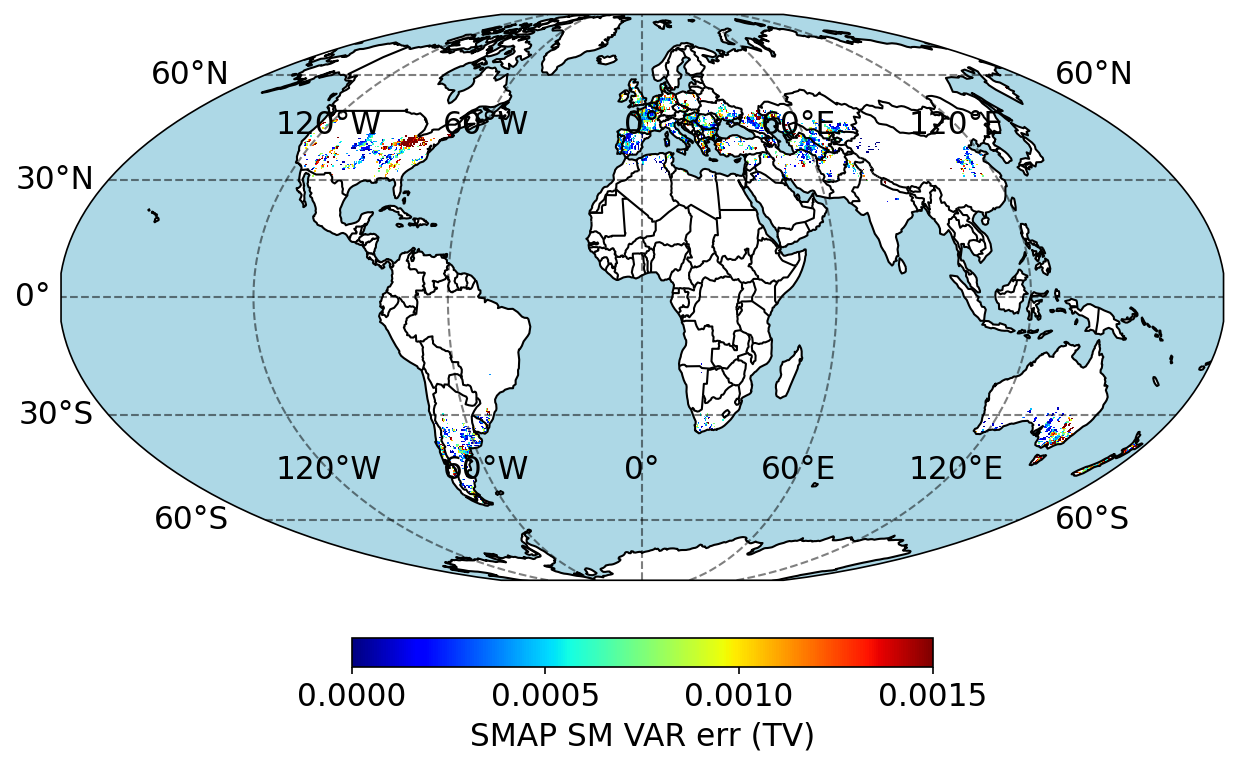

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [9]:
'''
target = np.nanmean(check_temp_TV[:, :, :3000], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0015, label_title=f'SMAP SM VAR err (TV)')

target = np.nanmean(check_temp_TV[:, :, 3000:5000], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0015, label_title=f'SMAP SM VAR err (TV)')

target = np.nanmean(check_temp_TV[:, :, 5000:], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0015, label_title=f'SMAP SM VAR err (TV)')
'''
stamp = datetime(2022, 1, 1) - datetime(2015, 2, 1)
target_idx = stamp.days * 2

target = check_temp_TV[:, :, target_idx] #np.nanmean(check_temp_TV[:, :, 3000:5000], axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.0015, label_title=f'SMAP SM VAR err (TV)')